In [91]:
import pandas as pd
import matplotlib.pyplot as plt

from river.linear_model import LinearRegression
from river.metrics import MAE
from river.compose import Pipeline, TransformerUnion
from river.preprocessing import StandardScaler
from river.base import Transformer


In [92]:
# Iniciamo o dataframe a partir do conjunto do número de atendimentos semais 
df = pd.read_csv("series_mesor.csv")
# Convertemos a coluna data em dados semanais para o formato date time
df.DATA = pd.to_datetime(df.DATA)
# Usaremos os dados depois da primeira observação, isto ocorre para os dados não terem um hiper salto
df = df.iloc[1:]


In [93]:
# Esta celula fara novas colunas para o dataframe a partir da coluna NUM_ATENDIMENTOS,
# faremos isso para ter novas variáveis que funcionem como preditoras
# Para este processo criaremos uma copia do dataframe original chamada de df1
df1 = df.copy()
# A variavel p especifica quantas novas colunas queremos criar
p = 5 
# Assim criamos um loop para criar as novas colunas desolcando o NUM_ATENDIMENTOS em uma 'casa' par baixo
for i in range(p):
    df1[f'x_{i+1}'] = df1.NUM_ATENDIMENTOS.shift(i+1)
# Após isso dropamos as colunas vazias (que são as 5 primeiras observações)    
df1.dropna(axis=0, inplace=True)


In [94]:
# Abaixo podemos ver as colunas do dataframe original
df.head()

,DATA,NUM_ATENDIMENTOS
1,2023-01-09,2532
2,2023-01-16,2344
3,2023-01-23,2581
4,2023-01-30,2362
5,2023-02-06,2650


In [95]:
# A partir deste estagio usaremos a biblioteca river, esta biblioteca é usada para o aprendizado em streaming
# O modulo stream da biblioteca river faz com que os dados sejam carregados no dataframe por lotes, 
# veja que os nosssos dados estão em um unico lote , para simular dados em straming faremos com que o dataframe seja carregado 
# iterações usando o stream.iter_pandas assim nossos dados chegarão como se fosse dados em streaming
from river import stream
# Criar um stream a partir do DataFrame
df['days_since_start'] = (df['DATA'] - df['DATA'].min()).dt.days #não sera necessaria
# A variavel stream_dataset é nosso objeto que faracom que os dados cheguem como se estivesse em streaming
# as variáveis x_1,x_2,x_3,x_4,x_5 serão as variáveis que usarem para prever a variável NUM_ATENDIMENTOS
stream_dataset = stream.iter_pandas(X=df1[['x_1','x_2','x_3','x_4','x_5']], y=df1['NUM_ATENDIMENTOS'])
# O objeto model funciona com um pipeline e usar o standartScaler e a regressão linear como modelo
model = StandardScaler() | LinearRegression()
# A seguir criamos um array para guardar as preduções que o modelo fará
y_pred = []
# As ideias a seguir serão intuitivas. 
# Ao iterar nosso dataframe é como se os dados estivessem chegando em streaming pois chegam um a um
#  Isso permite que o modelo veja um novo dado a cada iteração
for X, y in stream_dataset:
    # O modulo predict_one retorna a previsão do modelo para uma única observação usando o Valor X 
    # que são as coulnas que usamos para prever o dataframe
    y_pred.append(model.predict_one(X))
    # O modulo learn_one 
    # atualiza o estado interno do modelo dada uma nova observação que contém recursos de entrada xe valor alvo y
    # Isto serve para atualizar o modelo, ensinando os valores e ajustando o seu aprendizado e o modelo LinearRegression()
    model.learn_one(X, y)
    

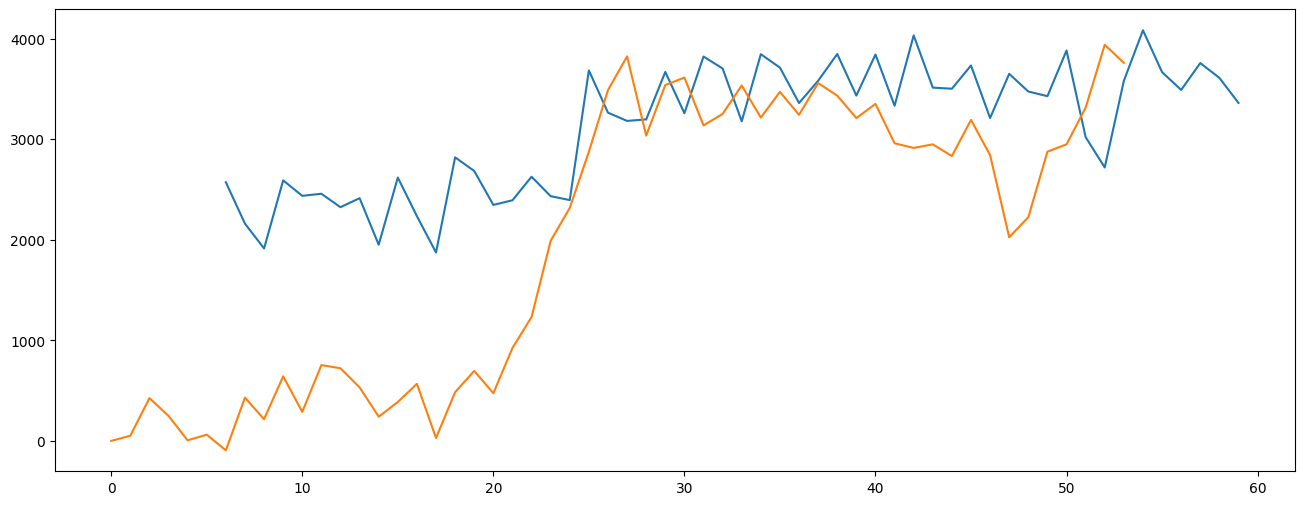

In [96]:
# A seguir plotamos os resultados do modelo comparando com os dados originais
# Como foram excluidas as colunas nulas do df é preciso remover para comparar o modelo
plt.figure(figsize=(16,6))
plt.plot(df1['NUM_ATENDIMENTOS'])
plt.plot(y_pred)

2024-02-26 00:00:00 3324.222
2024-03-04 00:00:00 3473.249
2024-03-11 00:00:00 3360.980
2024-03-18 00:00:00 3024.915
2024-03-25 00:00:00 3018.815
2024-04-01 00:00:00 3360.261
2024-04-08 00:00:00 3898.008
2024-04-15 00:00:00 3457.547
2024-04-22 00:00:00 3275.226
2024-04-29 00:00:00 3514.579
2024-05-06 00:00:00 3163.380
2024-05-13 00:00:00 3170.672


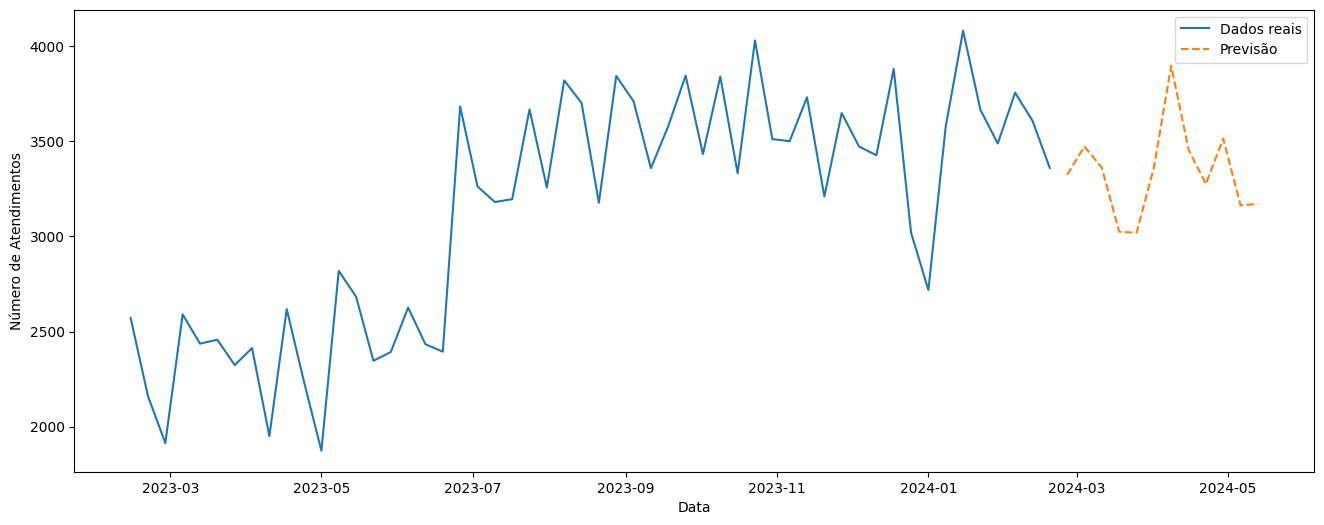

In [97]:
import datetime as dt
from river import datasets
from river import time_series
from river import utils

period = 12
model = time_series.SNARIMAX(
    p=period,
    d=1,
    q=period,
    m=period,
    sd=1
)

stream_dataset = stream.iter_pandas(X=df1[['x_1','x_2','x_3','x_4','x_5']], y=df1['NUM_ATENDIMENTOS'])
'''
y_pred = []

for X,y in stream_dataset:
    model.learn_one(y)
    '''
for t, row in df1.iterrows():
    x = {'DATA': row['DATA']}
    y = row['NUM_ATENDIMENTOS']
    model.learn_one(y, X)
    
horizon = 12
future = [
    {'DATA': df['DATA'].max() + pd.to_timedelta(7 * i, unit='D')}
    for i in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon)

for X, y_pred in zip(future, forecast):
    print(X['DATA'], f'{y_pred:.3f}')
    
    
    

# Realize a previsão
forecast = model.forecast(horizon=horizon)

# Combine os dados reais e as previsões para plotagem
df_future = pd.DataFrame(future)
df_future['NUM_ATENDIMENTOS'] = forecast

# Plote os dados reais e as previsões
plt.figure(figsize=(16, 6))
plt.plot(df1['DATA'], df1['NUM_ATENDIMENTOS'], label='Dados reais')
plt.plot(df_future['DATA'], df_future['NUM_ATENDIMENTOS'], label='Previsão', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Número de Atendimentos')
plt.legend()
plt.show()    
    
    